In [5]:
import importlib
from torch import nn
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import datetime
from sklearn.metrics import roc_auc_score

import torch
from torchvision import transforms
import pandas as pd
import seaborn as sn
import src.distance_metrics

import src.ood_detection
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import EmpiricalCovariance, GraphicalLasso
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans 
#import statsmodels.api as sm 
from scipy import stats
import pandas as pd
import seaborn as sns
#from distfit import distfit
from scipy.stats import gamma
import scipy.stats as stats
import src.datasets

import os
from PIL import Image
import h5py
import torch.optim as optim
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any, Sequence
import math

In [6]:
#!pip install h5py

In [7]:
def preprocess_images(input_dir, output_dir):
    with h5py.File(os.path.join(input_dir, '3dshapes.h5'), 'r') as dataset:
        data = dataset['images'][:]  # Assuming this fits into memory; otherwise, process in chunks.
    
    # Resize images (example using OpenCV for batch processing could be faster)
    resized_images = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in data])

    # Save preprocessed data
    with h5py.File(os.path.join(output_dir, '3dshapes_preprocessed.h5'), 'w') as f:
        f.create_dataset('images', data=resized_images)
#preprocess_images("../data/Fast_3DShapes/raw","../data/Fast_3DShapes/processed")

In [8]:
def denormalize(normalized, basis):
    return basis.min() + (basis.max() - basis.min())*((normalized + 1)/2)

def normalize(unnormalized, basis):
    return (2 * (unnormalized - basis.min()) / (basis.max() - basis.min()) - 1)

def normalize_feat_wise(unnormalized, basis):
    return (2 * (unnormalized - basis.min(0)) / (basis.max(0) - basis.min(0)) - 1)

def denormalize_feat_wise(normalized, basis):
    return basis.min(0) + (basis.max(0) - basis.min(0))*((normalized + 1)/2)

def denormalize_std(normalized, basis):
    return normalized * basis.std(0) + basis.mean(0)

def normalize_std(unnormalized, basis):
    return (unnormalized - basis.mean(0))/basis.std(0)

def feature_normalize(X, axis=1, eps=1e-12):
    """Normalize along axis (rows if axis=1) with numerical stability. From mahalanobis ++"""
    X = np.asarray(X)
    norms = np.linalg.norm(X, ord=2, axis=axis, keepdims=True)
    return X / np.clip(norms, eps, None)



In [16]:
def show_images_grid(
    data,
    filenames: Sequence[str],
    max_cols: int = 10,
    titles: Optional[Sequence[str]] = None,
    figsize_per_cell: float = 2.0,
    turn_off_axes: bool = True,
    save_path: Optional[str] = None,
):
    """
    Display images in a grid with up to `max_cols` columns.

    Args:
        root: Root directory for images (can be "" if `filenames` are absolute).
        filenames: List of image paths (relative to `root`, or absolute paths).
        max_cols: Maximum number of columns in the grid.
        titles: Optional list of titles per image (same length as filenames).
        figsize_per_cell: Size multiplier for each cell in inches.
        turn_off_axes: If True, hides axes.
        save_path: If provided, saves the figure to this path.

    Returns:
        (fig, axes) from matplotlib for further customization.
    """
    
    paths = []
    infos = []
    for name in filenames:
        p = int(name.split("/")[2].split("_")[0])
        infos.append(name.split("/")[2])
        paths.append(p)

    # Load images (RGB), skipping missing ones with a warning
    imgs, kept_paths, kept_titles = [], [], []
    for i, p in enumerate(paths):
        try:
            img = data[p]
            imgs.append(img)
            kept_paths.append(infos[i])
            if titles is not None and i < len(titles):
                kept_titles.append(infos[i])
            else:
                kept_titles.append(None)
        except Exception as e:
            print(f"[warn] Could not load {p}: {e}")

    n = len(imgs)
    if n == 0:
        print("No images to display.")
        return None, None

    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    fig_w = max(1, cols * figsize_per_cell)
    fig_h = max(1, rows * figsize_per_cell)
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = np.array(axes, dtype=object).reshape(rows, cols)  # handles 1D cases

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            if idx < n:
                ax.imshow(imgs[idx])
                if turn_off_axes:
                    ax.axis("off")
                if kept_titles[idx]:
                    ax.set_title(str(kept_titles[idx]), fontsize=9)
            else:
                ax.axis("off")
            idx += 1

    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=200)

    plt.show()

    return fig, axes

def split_names_to_dict(name_list, append = False, labels_dict = None ):
    if ~append:
        labels_dict = {"fh":[],"wh":[],"oh":[],"sc":[],"sh":[] ,"or":[] }
    for name in name_list:
        spltted_name = name.split("_")
        labels_dict["fh"].append(int(spltted_name[2][2:]))
        labels_dict["wh"].append(int(spltted_name[3][2:]))
        labels_dict["oh"].append(int(spltted_name[4][2:]))
        labels_dict["sc"].append(int(spltted_name[5][2:]))
        labels_dict["sh"].append(int(spltted_name[6][2:]))
        labels_dict["or"].append(int(spltted_name[7][2:].split(".")[0]))

    return labels_dict

#### Load the data

In [10]:
with h5py.File(os.path.join("./shapes3d", '3dshapes.h5'), 'r') as dataset:
    data = dataset['images'][:]  # Assuming this fits into memory; otherwise, process in chunks.
    

#### Load the activations

In [11]:
epoch = 1
seed = "" #_s2 : hue; s3 : or; s4: fh
shapes_te_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_te_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val.npy")
shapes_tr_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train_names.npy").flatten()
shapes_tr_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train.npy")




In [14]:
shapes_te_acts.shape

(48000, 512)

In [17]:
# get all the labels from image names
tr_labels = split_names_to_dict(shapes_tr_names)


In [21]:
pd.Series(tr_labels['sh']).value_counts()

0    12000
3    12000
1    12000
2    12000
Name: count, dtype: int64

## SAE time


**Definitions of the summary statistics of SAE latents from Lim et al. 2024**

**Sparsity (activated frequency)** represents how frequently this latent is activated. We count the number of images having positive SAE latent activations and divide by the total number of seen images. An SAE latent with a high frequency either represents a common concept or is an uninterpretable (noisy) latent.

**Mean activation value** is computed by averaging the positive activation value among the activated samples. The mean activation value implies the SAE model’s confidence. A latent direction is more likely to represent a meaningful concept if it has a high 
mean activation value.

**Label entropy** measures how many unique labels activate the latent. Precisely, we compute the probability of a label based on its activation value and compute the entropy as
 $$prob_c = \frac{sum_c}{\sum_{c\in C}sum_c},\quad  entropy = − \sum_{c\in C} (prob_c \log prob_c), (2)$$ 
where $sum_c$ is the summed activation values for label c ∈ C. The entropy being equal to zero indicates that all reference images have exactly the same label. Higher entropy indicates that more labels contribute to the latent’s activation.

**Label standard deviation.** In ImageNet, class labels are organized in a hierarchical structure based on WordNet’s semantic relationships [8, 22]. We leverage this label structure and use the label standard deviation of reference images as a clue for the semantic granularity besides the label entropy when exploring the latents.

In [22]:
from src.base_sae import SparseAutoencoder
from src.sae_utils import *

#### Train a SAE

In [23]:
epoch = 1
seed = "" #can be left "" if folder does not exist
normalization_on = True # feature normalized or not
shapes_te_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val_names.npy").flatten()
shapes_te_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_val.npy")
shapes_tr_names = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train_names.npy").flatten()
shapes_tr_acts = np.load(f"./activations/shapes3d_SN{seed}/epoch{epoch}/resnet18_shapes3d_train.npy")

if normalization_on:
    shapes_tr_acts = feature_normalize(shapes_tr_acts)
    shapes_te_acts = feature_normalize(shapes_te_acts)


tr_labels = split_names_to_dict(shapes_tr_names)
te_labels = split_names_to_dict(shapes_te_names)

latents = torch.tensor(shapes_tr_acts)



In [24]:
# Build and train SAE
expansion_coef = 5
input_dim = 512
epochs = 10

sae = SparseAutoencoder(input_dim=input_dim, code_dim=input_dim*expansion_coef,tied_weights=False)
train_sae(sae, latents, epochs=epochs, l1_lambda=5e-3,verbose_every=5,)

ckpt_file = Path(f"sae_{seed}_{epoch}_SN_reg{str(normalization_on)}.pt")
save_checkpoint(sae, ckpt_file, meta={"epochs": epochs})




Epoch   1/10 | loss 0.000080  l1 0.000019  dead% 27.85  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0585
Epoch   5/10 | loss 0.000010  l1 0.000004  dead% 86.52  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0586
Epoch  10/10 | loss 0.000008  l1 0.000003  dead% 88.67  dup_pairs 0  dup_ratio 0.0000  |offdiag| 0.0577
Checkpoint saved to sae__1_SN_regTrue.pt


In [37]:

# Save a checkpoint
ckpt_file = Path(f"sae_{seed}_{epoch}_SN_reg.pt")
# Reload model
sae = load_checkpoint(ckpt_file)

# Grab top activations for concept 13


In [26]:
stats = concept_summary_stats(sae, latents, torch.tensor(tr_labels["sh"]), top_k=None)
most_specific = rank_concepts(stats, key="label_entropy", ascending=False, top_n=30, return_scores=True)
print("Top 10 most label‑diverse concepts (high entropy):")
for cid, sc in most_specific:
    print(f"  Concept {cid:4d} | entropy = {sc:.3f}")
most_common= rank_concepts(stats, key="sparsity", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high sparsity):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | sparsity = {sc:.3f}")
most_common= rank_concepts(stats, key="mean_activation", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high activation):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | mean_activation = {sc:.3f}")
most_common= rank_concepts(stats, key="label_std", ascending=False, top_n=10, return_scores=True)
print("Top 10 most common concepts (high label_std):")
for cid, sc in most_common:
    print(f"  Concept {cid:4d} | std = {sc:.3f}")

c:\Users\b03120\Documents\VS workspaces\contextual-calibration\src\sae_utils.py:347: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  std = float(numeric_labels[active_mask].std())


Top 10 most label‑diverse concepts (high entropy):
  Concept 2157 | entropy = 1.996
  Concept 2228 | entropy = 1.992
  Concept 1483 | entropy = 1.991
  Concept 2011 | entropy = 1.991
  Concept  116 | entropy = 1.990
  Concept 1638 | entropy = 1.990
  Concept 1536 | entropy = 1.989
  Concept 2461 | entropy = 1.989
  Concept 1416 | entropy = 1.986
  Concept 1129 | entropy = 1.985
  Concept 1830 | entropy = 1.984
  Concept 2448 | entropy = 1.983
  Concept  936 | entropy = 1.983
  Concept 1841 | entropy = 1.978
  Concept 1749 | entropy = 1.978
  Concept  247 | entropy = 1.977
  Concept 2384 | entropy = 1.976
  Concept  440 | entropy = 1.976
  Concept 1798 | entropy = 1.976
  Concept 1717 | entropy = 1.972
  Concept 1455 | entropy = 1.967
  Concept  979 | entropy = 1.964
  Concept  748 | entropy = 1.958
  Concept 2130 | entropy = 1.956
  Concept 1488 | entropy = 1.955
  Concept  725 | entropy = 1.953
  Concept 2280 | entropy = 1.953
  Concept  173 | entropy = 1.952
  Concept 2041 | entropy 

#### choose specific neuron subsets by sparsity other metrics

In [27]:
criteria = {
    "sparsity":        (None, None),   # upper-bounded
    "label_entropy":   (None,None),    # upper-bounded
    "mean_activation": (None, None ),   # lower-bounded
    "label_std" : (None,None)
}


picked = query_concepts(stats,
                        bounds=criteria,
                        sort_key="label_entropy",  # any metric in the dict
                        ascending=True,            # smallest entropy first
                        return_scores=True)        # → [(id, metric_dict), …]


In [28]:
picked_keys= [i[0] for i in picked]
picked_keys

[62,
 67,
 115,
 126,
 128,
 148,
 188,
 271,
 333,
 339,
 355,
 367,
 379,
 428,
 444,
 532,
 607,
 662,
 667,
 684,
 717,
 869,
 905,
 945,
 1016,
 1044,
 1074,
 1194,
 1221,
 1230,
 1261,
 1295,
 1362,
 1371,
 1432,
 1437,
 1454,
 1463,
 1497,
 1500,
 1520,
 1564,
 1590,
 1592,
 1628,
 1713,
 1714,
 1718,
 1766,
 1849,
 1864,
 1999,
 2010,
 2090,
 2098,
 2100,
 2114,
 2117,
 2137,
 2177,
 2255,
 2398,
 2406,
 2549,
 2555,
 1225,
 2131,
 72,
 2355,
 489,
 1187,
 929,
 518,
 1364,
 478,
 2358,
 269,
 581,
 1780,
 2286,
 1336,
 47,
 658,
 424,
 1180,
 627,
 1829,
 1338,
 1604,
 656,
 2193,
 1259,
 499,
 2296,
 1551,
 2144,
 985,
 2394,
 1992,
 1548,
 2447,
 310,
 2205,
 1896,
 706,
 1843,
 411,
 2292,
 2121,
 1982,
 1922,
 223,
 1737,
 356,
 2371,
 1957,
 1357,
 566,
 256,
 264,
 2245,
 1612,
 1769,
 1419,
 1833,
 829,
 1814,
 2088,
 286,
 2181,
 978,
 1498,
 1505,
 1684,
 1907,
 888,
 763,
 2330,
 1008,
 1055,
 194,
 737,
 1096,
 1636,
 1522,
 1633,
 48,
 777,
 2257,
 1757,
 2081,
 23

#### draw the selection

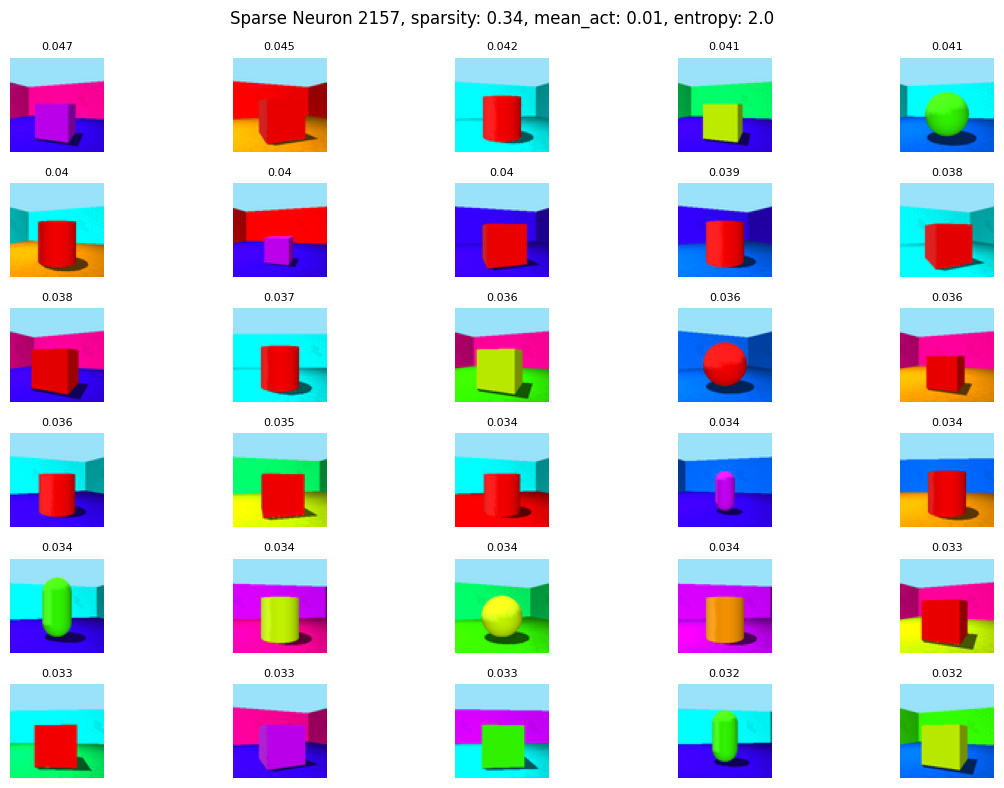

In [29]:
concept = picked_keys[-1]
top_idx, top_act = most_activated_indices(sae, latents, concept, k=30)

plot_top_k_images(shapes_tr_names[top_idx],data,figsize=(12,8),top_act = top_act.detach().numpy(),stats=stats[concept],neuron_nr=concept)

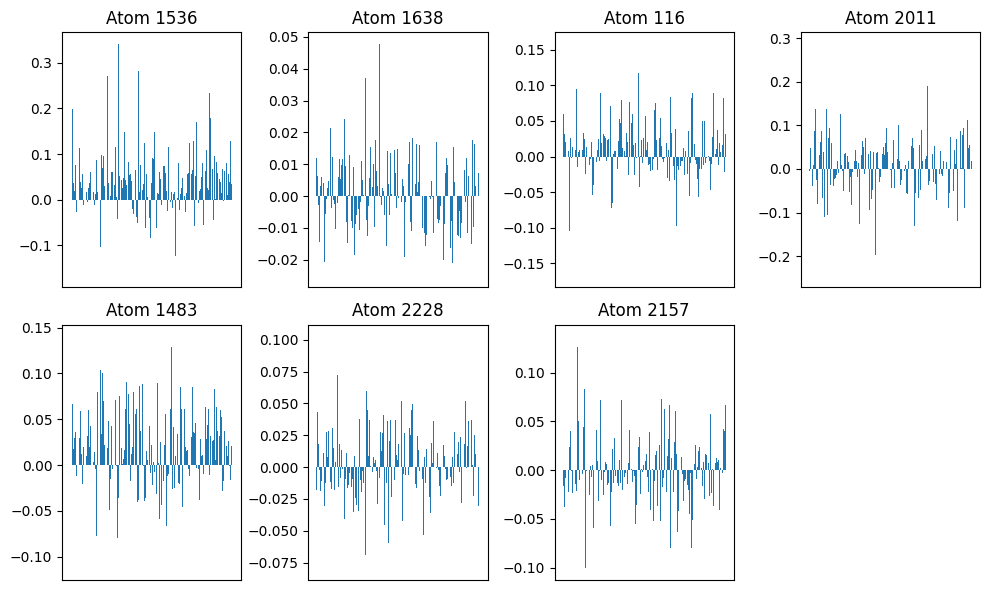

In [30]:
# Visualise dictionary atoms & top images 
atom_indexes = picked_keys[-7:]
plot_dictionary_atoms(sae, num_atoms=len(atom_indexes),atom_indexes_bool=True,atom_indexes=atom_indexes)




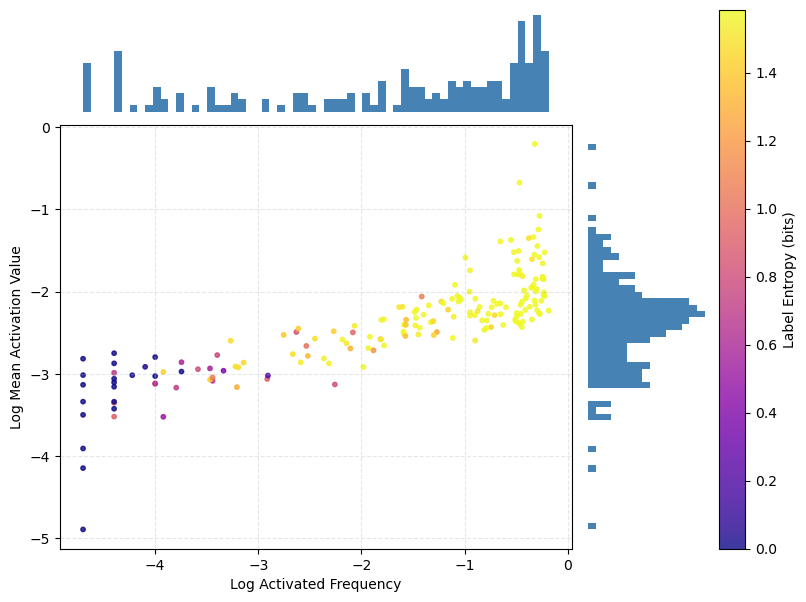

In [191]:
plot_metrics_figure(stats)